In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True) 
plt.rc("font",family = 'SimHei')

In [2]:
#设置变量
df = pd.read_excel("./第二问2.xlsx")
# 假设'PCL总分'是因变量，其他列是自变量
X = df.drop('PCL总分', axis=1)
y = df['PCL总分']


# 构建多模态数据的PTSD风险评估模型

## 多元线性回归

采用留一法进行测试集和训练集的划分
留一法（Leave-One-Out, LOO）: 当数据量非常少时，可以使用留一法，即将K设置为数据的数量（N-1），每次留下一个样本作为测试集，其余作为训练集。对于25条数据，这意味着您将进行24次训练和测试。

In [239]:
from sklearn.linear_model import LinearRegression

# 假设X和y是数据集

# 初始化留一法交叉验证器
loo = LeaveOneOut()

train_model_scores = []
test_model_scores = []

# 留一法交叉验证
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 创建并训练模型
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # 进行预测
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 计算均方误差
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_model_scores.append(train_mse)
    test_model_scores.append(test_mse)

# 计算所有模型性能估计值的平均值
train_average_mse = sum(train_model_scores) / len(train_model_scores)
test_average_mse = sum(test_model_scores) / len(test_model_scores)

print(f'训练集的均方误差(MSE): {train_average_mse}')
print(f'测试集的均方误差(MSE): {test_average_mse}')

# 使用全部数据训练最终模型
final_model = LinearRegression()
final_model.fit(X, y)

#输出结果
feature_names = ['ASD再体验', 'ASD回避', 'ASD警觉','心理韧性','吸烟状态=不吸烟，被动吸烟',
                 '吸烟状态=吸烟','专注度','放松','REGR factor score 1','REGR factor score 2'] 

# 创建一个字典，将特征名称和对应的系数对应起来
coefficients_dict = {feature_names[i]: model.coef_[i] for i in range(len(feature_names))}

# 输出字典
print(f'Coefficients: {coefficients_dict}')

训练集的均方误差(MSE): 5.752768343580591
测试集的均方误差(MSE): 238.82032592520756
Coefficients: {'ASD再体验': -0.37355787409077873, 'ASD回避': 1.8807178468481547, 'ASD警觉': 2.1200676429755583, '心理韧性': -0.11819235398828802, '吸烟状态=不吸烟，被动吸烟': 0.03422940432251102, '吸烟状态=吸烟': -0.7267481583807591, '专注度': 0.07263062531694475, '放松': 0.15074962135371542, 'REGR factor score 1': 0.8313972598813055, 'REGR factor score 2': 1.1929869179231627}


### 用最终训练出来的模型对全部数据进行预测，得到误差结果

In [240]:
data_mse = 0
y_pred_1 = model.predict(X)
for i in range(len(y_pred_1)):
    data_mse += (y_pred_1[i] - y[i])**2
data_mse = data_mse/len(y_pred_1)
print(f'最终模型预测的 Mean Squared Error: {data_mse}')

最终模型预测的 Mean Squared Error: 6.029699014789758


In [241]:
#在结果处理上，我们将预测出来得分小于0的设置为0
np.set_printoptions(suppress=True) 
y_pred_1 = model.predict(X)
data_array_clipped = np.clip(y_pred_1, a_min=0, a_max=None)
print(data_array_clipped)

[ 1.01427848 17.6044845   0.66973643 20.2390671   0.45245817  2.70815117
  0.         16.80870968 29.87343077  0.          1.472526    0.
 36.41249237 20.12656923  0.66185428  0.          0.          1.56831113
  0.         17.9852468  13.08757853 21.93944035  0.          0.
  8.55350358]


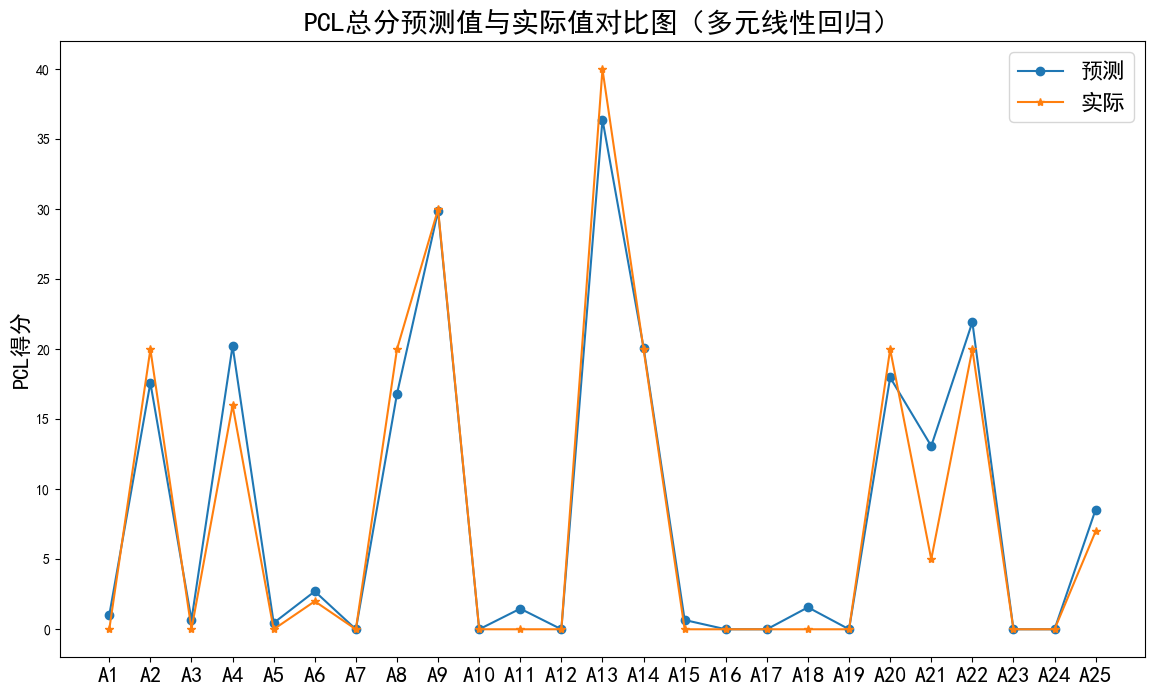

In [242]:
#画图
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))

a = range(1,26)
plt.plot(a, data_array_clipped, label="预测", marker='o')  # 添加marker来标记每个数据点
plt.plot(a, y, label="实际", marker='*')  # 同样为实际数据添加marker

#x坐标
_xtick_labels = ["A{}".format(i) for i in a]
plt.xticks(a,_xtick_labels,fontsize=16)

#添加标题
plt.ylabel('PCL得分',fontsize=16)
plt.title('PCL总分预测值与实际值对比图（多元线性回归）',fontsize=20) 
#添加图例
plt.legend(loc = 1,fontsize=16)#loc代表位置
plt.show()

集成方法:

考虑使用集成学习方法，如随机森林或梯度提升机，这些方法可以更好地处理小数据集。

## 随机森林预测

### 确定n_estimators的数量
结果：在n_estimators等于300以后就是稳定的震荡

In [243]:
#确定n_estimators的数量
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model_scores = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
# 创建并训练模型
for i in range (1,401):
    model = RandomForestRegressor(n_estimators=i)
    model.fit(X_train, y_train)
    # 进行预测
    y_pred = model.predict(X_test)
        
    # 计算均方误差
    mse = mean_squared_error(y_test, y_pred)
    model_scores.append(mse)

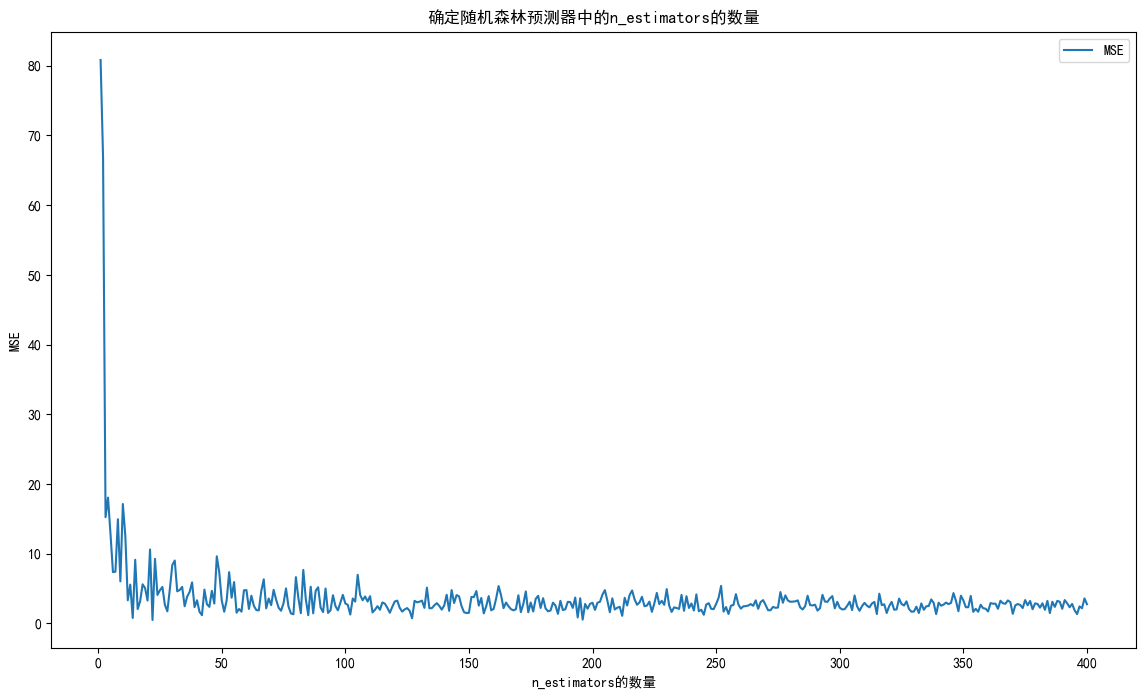

In [244]:
plt.figure(figsize=(14,8))

a = range(1,401)
plt.plot(a, model_scores, label="MSE")  # 添加marker来标记每个数据点

# #x坐标
# _xtick_labels = ["{}".format(i) for i in a]
# plt.xticks(a,_xtick_labels)

#添加标题
plt.ylabel('MSE')
plt.xlabel('n_estimators的数量')
#n_estimators：森林中树木的数量。
plt.title('确定随机森林预测器中的n_estimators的数量') 
#添加图例
plt.legend(loc = 1,)#loc代表位置
plt.show()
#画图



### 构建随机森林预测，我们采用留一法对划分数据集和测试集

In [263]:
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 假设X和y是数据集

# 初始化留一法交叉验证器
loo = LeaveOneOut()

train_model_scores = []
test_model_scores = []

# 留一法交叉验证
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 创建并训练随机森林模型
    model = RandomForestRegressor(n_estimators=300,random_state=42)  # 可以设置随机状态以确保可复现性
    model.fit(X_train, y_train)
    
    # 进行预测
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 计算均方误差
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_model_scores.append(train_mse)
    test_model_scores.append(test_mse)

# 计算所有模型性能估计值的平均值
train_average_mse = sum(train_model_scores) / len(train_model_scores)
test_average_mse = sum(test_model_scores) / len(test_model_scores)

print(f'训练集的均方误差(MSE): {train_average_mse}')
print(f'测试集的均方误差(MSE): {test_average_mse}')

# 使用全部数据训练最终的随机森林模型
final_model = RandomForestRegressor(random_state=42)  # 确保与交叉验证中使用的随机状态相同
final_model.fit(X, y)

# 输出结果
feature_names = ['ASD再体验', 'ASD回避', 'ASD警觉','心理韧性','吸烟状态=不吸烟，被动吸烟',
                 '吸烟状态=吸烟','专注度','放松','REGR factor score 1','REGR factor score 2']

# 随机森林模型没有系数，但可以输出特征重要性
feature_importances = model.feature_importances_
importances_dict = {feature_names[i]: feature_importances[i] for i in range(len(feature_names))}

print(f'Feature Importances: {importances_dict}')

训练集的均方误差(MSE): 5.3619262962962955
测试集的均方误差(MSE): 43.68253511111111
Feature Importances: {'ASD再体验': 0.20285779844481763, 'ASD回避': 0.3676087885218424, 'ASD警觉': 0.3459354124517493, '心理韧性': 0.026816021380526373, '吸烟状态=不吸烟，被动吸烟': 0.0013687403175778978, '吸烟状态=吸烟': 0.0022919996812868714, '专注度': 0.011643590017577117, '放松': 0.009471898154029153, 'REGR factor score 1': 0.020730238548119975, 'REGR factor score 2': 0.011275512482473412}


### 用最终训练出来的模型对全部数据进行预测，得到误差结果

In [264]:
data_mse = 0
y_pred_1 = model.predict(X)
for i in range(len(y_pred_1)):
    data_mse += (y_pred_1[i] - y[i])**2
data_mse = data_mse/len(y_pred_1)
print(f'最终模型预测的 Mean Squared Error: {data_mse}')

最终模型预测的 Mean Squared Error: 6.015568000000001


### 因为评分不能为负数，因此我们将小于0的平分改为0

In [265]:
#在结果处理上，我们将预测出来得分小于0的设置为0
np.set_printoptions(suppress=True) 
y_pred_1 = model.predict(X)
data_array_clipped = np.clip(y_pred_1, a_min=0, a_max=None)
print(data_array_clipped)

[ 0.21333333 17.49        0.08333333 17.06333333  0.00666667  1.22
  0.07666667 19.02       23.84        0.00666667  0.01333333  0.
 32.91666667 19.69333333  0.05333333  0.05333333  0.02        2.31666667
  0.35666667 18.89333333 11.13666667 20.18        0.05333333  0.12666667
  9.94666667]


### 画图展示预测结果

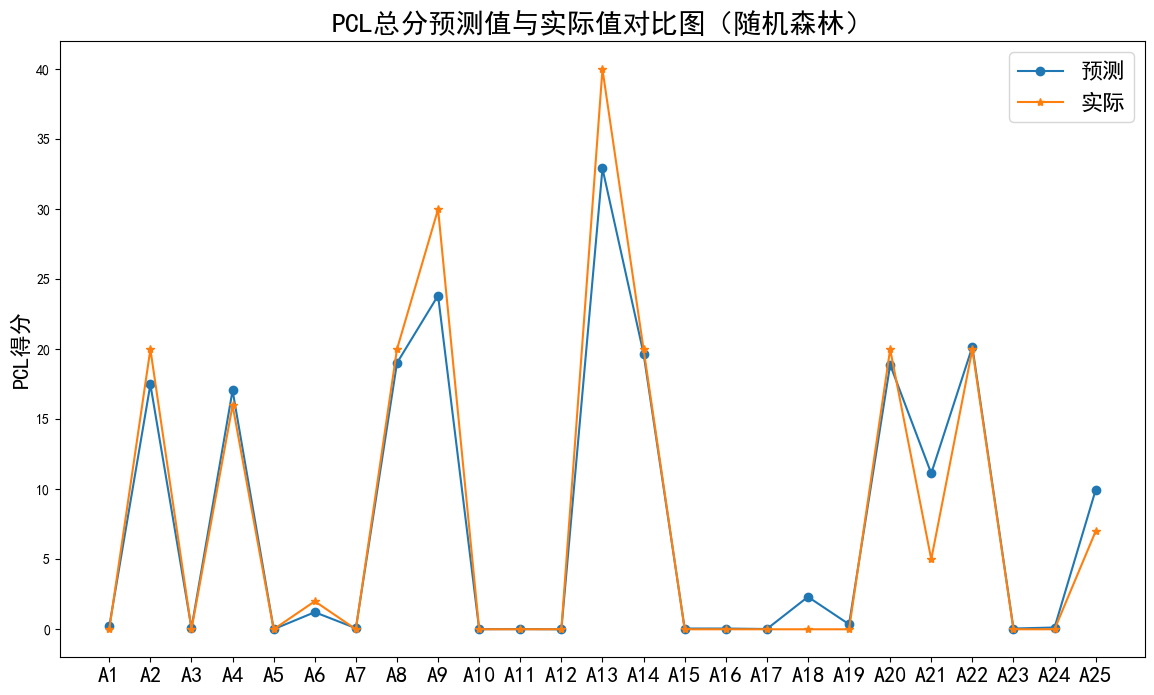

In [266]:
#画图
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))

a = range(1,26)
plt.plot(a, data_array_clipped, label="预测", marker='o')  # 添加marker来标记每个数据点
plt.plot(a, y, label="实际", marker='*')  # 同样为实际数据添加marker

#x坐标
_xtick_labels = ["A{}".format(i) for i in a]
plt.xticks(a,_xtick_labels,fontsize=16)

#添加标题
plt.ylabel('PCL得分',fontsize=16)
plt.title('PCL总分预测值与实际值对比图（随机森林）',fontsize=20) 
#添加图例
plt.legend(loc = 1,fontsize=16)#loc代表位置
plt.show()

## 梯度提升机预测

### 确定n_estimators的数量
结果：在n_estimators等于500以后就是稳定的震荡

In [249]:
#确定n_estimators的数量
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

model_scores = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
# 创建并训练模型
for i in range (1,801):
    model = GradientBoostingRegressor(n_estimators=i,learning_rate = 0.01)
    model.fit(X_train, y_train)
    # 进行预测
    y_pred = model.predict(X_test)
        
    # 计算均方误差
    mse = mean_squared_error(y_test, y_pred)
    model_scores.append(mse)

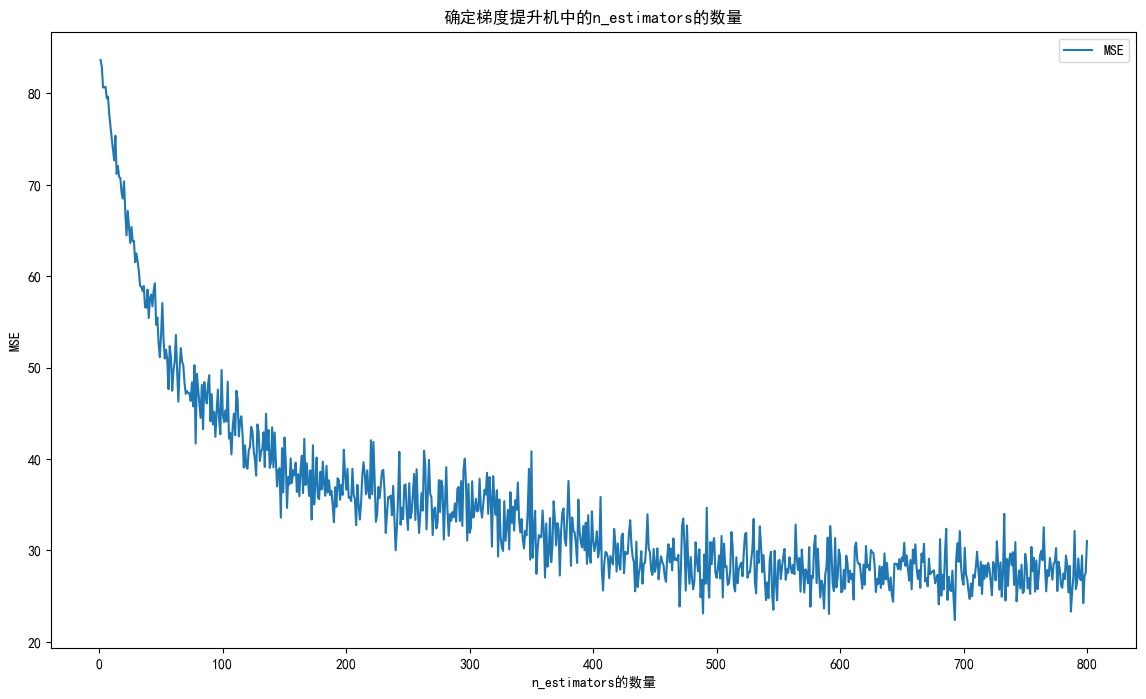

In [250]:
plt.figure(figsize=(14,8))

a = range(1,801)
plt.plot(a, model_scores, label="MSE")  # 添加marker来标记每个数据点

#添加标题
plt.ylabel('MSE')
plt.xlabel('n_estimators的数量')
#n_estimators：弱学习器的数量。
plt.title('确定梯度提升机中的n_estimators的数量') 
#添加图例
plt.legend(loc = 1,)#loc代表位置
plt.show()
#画图



### 构建梯度提升机模型预测，我们采用留一法对划分数据集和测试集

In [251]:
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# 假设X和y是数据集

# 初始化留一法交叉验证器
loo = LeaveOneOut()

train_model_scores = []
test_model_scores = []

# 留一法交叉验证
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 创建并训练梯度提升决策树模型
    model = GradientBoostingRegressor(n_estimators=300, random_state=42)  # 可以设置随机状态以确保可复现性
    model.fit(X_train, y_train)
    
    # 进行预测
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 计算均方误差
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_model_scores.append(train_mse)
    test_model_scores.append(test_mse)

# 计算所有模型性能估计值的平均值
train_average_mse = sum(train_model_scores) / len(train_model_scores)
test_average_mse = sum(test_model_scores) / len(test_model_scores)

print(f'训练集的均方误差(MSE): {train_average_mse}')
print(f'测试集的均方误差(MSE): {test_average_mse}')

# 使用全部数据训练最终的梯度提升决策树模型
final_model = GradientBoostingRegressor(random_state=42)  # 确保与交叉验证中使用的随机状态相同
final_model.fit(X, y)

# 输出结果
feature_names = ['ASD再体验', 'ASD回避', 'ASD警觉','心理韧性','吸烟状态=不吸烟，被动吸烟',
                 '吸烟状态=吸烟','专注度','放松','REGR factor score 1','REGR factor score 2']

# 梯度提升决策树模型也没有系数，但可以输出特征重要性
feature_importances = model.feature_importances_
importances_dict = {feature_names[i]: feature_importances[i] for i in range(len(feature_names))}

print(f'Feature Importances: {importances_dict}')

训练集的均方误差(MSE): 5.723066827067268e-11
测试集的均方误差(MSE): 66.74340756289924
Feature Importances: {'ASD再体验': 0.00535541248132256, 'ASD回避': 0.6028690900255147, 'ASD警觉': 0.3253661092927181, '心理韧性': 0.035146346500501476, '吸烟状态=不吸烟，被动吸烟': 0.0009811815615666966, '吸烟状态=吸烟': 0.0005152677328870476, '专注度': 0.00041586874485611457, '放松': 0.006891002347937997, 'REGR factor score 1': 0.018397670118021403, 'REGR factor score 2': 0.0040620511946738}


### 用最终训练出来的模型对全部数据进行预测，得到误差结果

In [252]:
data_mse = 0
y_pred_1 = model.predict(X)
for i in range(len(y_pred_1)):
    data_mse += (y_pred_1[i] - y[i])**2
data_mse = data_mse/len(y_pred_1)
print(f'最终模型预测的 Mean Squared Error: {data_mse}')

最终模型预测的 Mean Squared Error: 0.8075333138656027


### 因为评分不能为负数，因此我们将小于0的平分改为0

In [253]:
#在结果处理上，我们将预测出来得分小于0的设置为0
np.set_printoptions(suppress=True) 
y_pred_1 = model.predict(X)
data_array_clipped = np.clip(y_pred_1, a_min=0, a_max=None)
print(data_array_clipped)

[ 0.00000023 19.99999963  0.00000002 16.0000002   0.          1.99999977
  0.00000019 20.00000036 29.99999983  0.          0.          0.
 39.99999983 19.99999995  0.          0.00000066  0.00000007  0.00000052
  0.         19.99999998  5.0000001  20.00000001  0.          0.00000024
 11.49314287]


### 画图展示预测结果

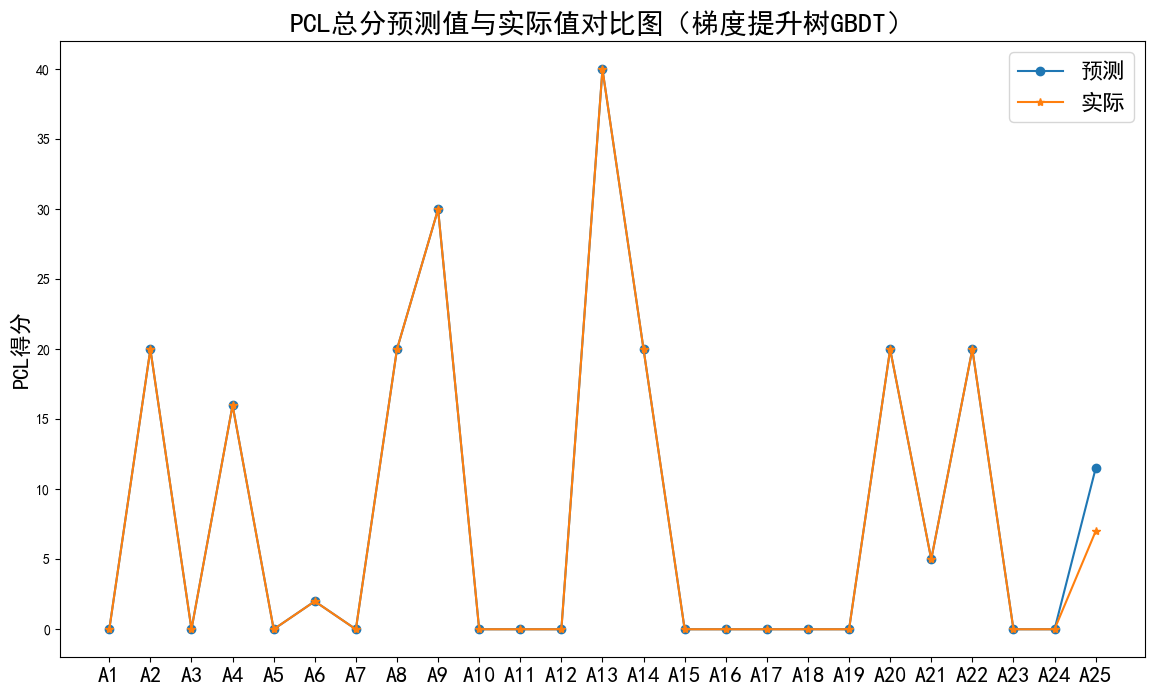

In [254]:
#画图
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))

a = range(1,26)
plt.plot(a, data_array_clipped, label="预测", marker='o')  # 添加marker来标记每个数据点
plt.plot(a, y, label="实际", marker='*')  # 同样为实际数据添加marker

#x坐标
_xtick_labels = ["A{}".format(i) for i in a]
plt.xticks(a,_xtick_labels,fontsize=16)

#添加标题
plt.ylabel('PCL得分',fontsize=16)
plt.title('PCL总分预测值与实际值对比图（梯度提升树GBDT）',fontsize=20) 
#添加图例
plt.legend(loc = 1,fontsize=16)#loc代表位置
plt.show()

## MLP神经网络预测

### 构建MLP神经网络模型预测，我们采用留一法对划分数据集和测试集

In [259]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# 假设X和y是数据集，X是Pandas DataFrame，y是Pandas Series或类似数组的结构

# 初始化留一法交叉验证器
loo = LeaveOneOut()

model_scores = []
train_model_scores = []

# 留一法交叉验证
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 创建并训练小型神经网络模型
    # 增加max_iter，使用早停法，调整学习率
    model = MLPRegressor(max_iter=5000, learning_rate_init=0.01, solver='adam',
                         early_stopping=True)
    model.fit(X_train, y_train)
    
    # 进行预测
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 计算均方误差
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_model_scores.append(train_mse)
    test_model_scores.append(test_mse)

# 计算所有模型性能估计值的平均值
train_average_mse = sum(train_model_scores) / len(train_model_scores)
test_average_mse = sum(test_model_scores) / len(test_model_scores)

print(f'训练集的均方误差(MSE): {train_average_mse}')
print(f'测试集的均方误差(MSE): {test_average_mse}')


# 使用全部数据训练最终小型神经网络模型
final_model = MLPRegressor()
final_model.fit(X, y)

训练集的均方误差(MSE): 53.16846213598029
测试集的均方误差(MSE): 49.9777466793851


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor()

### 用最终训练出来的模型对全部数据进行预测，得到误差结果

In [260]:
data_mse = 0
y_pred_1 = model.predict(X)
for i in range(len(y_pred_1)):
    data_mse += (y_pred_1[i] - y[i])**2
data_mse = data_mse/len(y_pred_1)
print(f'最终模型预测的 Mean Squared Error: {data_mse}')

最终模型预测的 Mean Squared Error: 21.366542394814438


### 因为评分不能为负数，因此我们将小于0的平分改为0

In [261]:
#在结果处理上，我们将预测出来得分小于0的设置为0
np.set_printoptions(suppress=True) 
y_pred_1 = model.predict(X)
data_array_clipped = np.clip(y_pred_1, a_min=0, a_max=None)
print(data_array_clipped)

[ 5.24512726 13.37780391  1.70410539 16.04251721  0.          1.35606864
  0.         16.60998723 18.83618742  0.          2.39947059  0.
 31.91167701 19.69598653  5.17999962  1.05550205  0.          1.07603723
  0.         14.75907001 10.29372357 19.15529595  0.          0.
 12.16342182]


### 画图展示预测结果

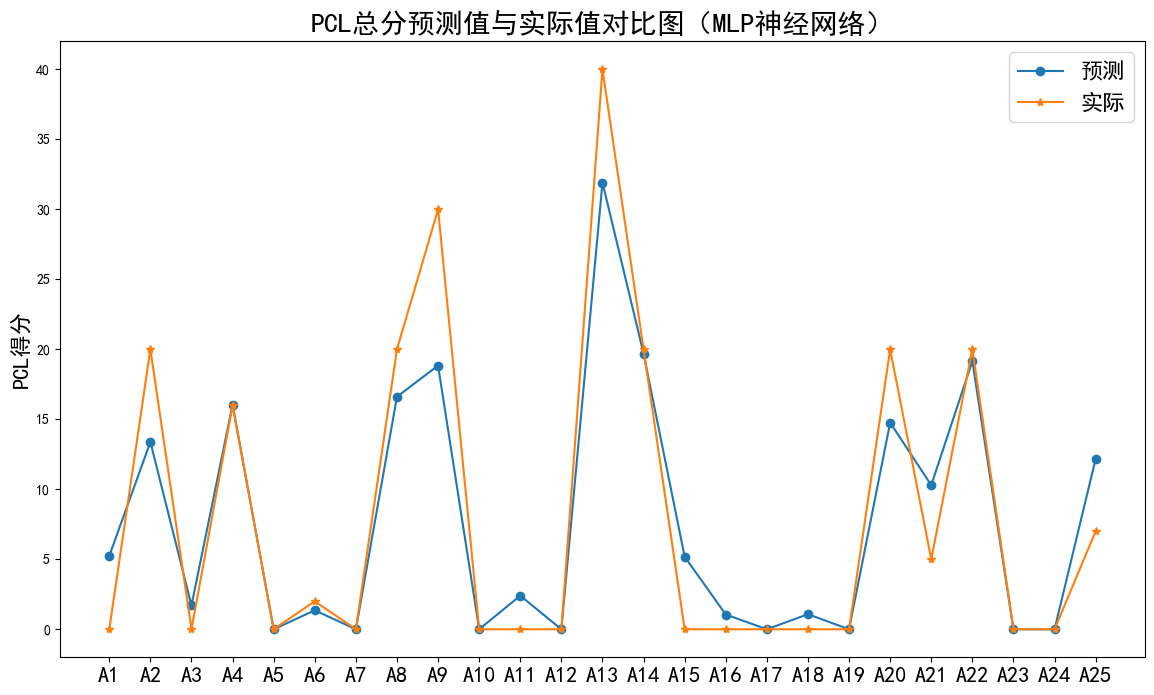

In [262]:
#画图
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))

a = range(1,26)
plt.plot(a, data_array_clipped, label="预测", marker='o')  # 添加marker来标记每个数据点
plt.plot(a, y, label="实际", marker='*')  # 同样为实际数据添加marker

#x坐标
_xtick_labels = ["A{}".format(i) for i in a]
plt.xticks(a,_xtick_labels,fontsize=16)

#添加标题
plt.ylabel('PCL得分',fontsize=16)
plt.title('PCL总分预测值与实际值对比图（MLP神经网络）',fontsize=20) 
#添加图例
plt.legend(loc = 1,fontsize=16)#loc代表位置
plt.show()